In [3]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler

# from typing import Any
from sklearn.metrics import r2_score

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from python.src.preprocess import (
    preprocess_bike_data,
)
from sklearn.svm import SVR

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

df_bike_processed["holiday"] = df_bike_processed["holiday"].map(
    {"HOLIDAY": 1, "NO HOLIDAY": 0}
)
df_bike_processed["season"] = df_bike_processed["season"].map(
    {
        "WINTER": 1,
        "SPRING": 2,
        "SUMMER": 3,
        "FALL": 4,
    }
)
df_bike_processed["workingday"] = df_bike_processed["workingday"].map(
    {"WORKING DAY": 1, "NO WORKING DAY": 0}
)
df_bike_processed["mnth"] = df_bike_processed["mnth"].map(
    {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
)
df_bike_processed["weekday"] = df_bike_processed["weekday"].map(
    {
        "SUN": 1,
        "MON": 2,
        "TUE": 3,
        "WED": 4,
        "THU": 5,
        "FRI": 6,
        "SAT": 7,
    }
)
df_bike_processed["weathersit"] = df_bike_processed["weathersit"].map(
    {"MISTY": 1, "GOOD": 2, "RAIN/SNOW/STORM": 3}
)
X = df_bike_processed.drop(columns="cnt")
y = df_bike_processed["cnt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index
)


In [24]:
svr = SVR()
svr.fit(X_train_scaled, y_train)

svr_predictions = svr.predict(X_train_scaled)  # Use training data for surrogate

tree_surrogate = DecisionTreeRegressor(max_depth=2)
tree_surrogate.fit(X_train, svr_predictions)  # Train on SVM predictions


surrogate_predictions = tree_surrogate.predict(X_train)
r_squared = r2_score(svr_predictions, surrogate_predictions)
print(f"R-squared of the surrogate model (Train): {r_squared:.2f}")
svr_predictions_test = svr.predict(X_test_scaled)
surrogate_predictions_test = tree_surrogate.predict(X_test)
r_squared_test = r2_score(svr_predictions_test, surrogate_predictions_test)
print(f"R-squared of the surrogate model (Test): {r_squared_test:.2f}")


R-squared of the surrogate model (Train): 0.80
R-squared of the surrogate model (Test): 0.75


In [25]:
# --- Inspecting the Terminal Nodes ---

# 1. Accessing the Tree Structure:
n_nodes = tree_surrogate.tree_.node_count
children_left = tree_surrogate.tree_.children_left
children_right = tree_surrogate.tree_.children_right
feature = tree_surrogate.tree_.feature
threshold = tree_surrogate.tree_.threshold
value = tree_surrogate.tree_.value  # The predictions at each node

# 2. Find the Terminal Nodes (leaves):
leaf_nodes = np.where(children_left == children_right)[0]


# 3. Print information about the leaf nodes:
for leaf_node in leaf_nodes:
    print(f"Leaf Node: {leaf_node}")
    print(
        f"  Prediction value: {value[leaf_node][0][0]:.2f}"
    )  # Get the numerical prediction

    # Trace the path to the leaf node (optional - requires more work) - see below.


# --- (Optional) Tracing the path to a leaf node ---
def get_rule(leaf_node, feature_names):
    rule = []
    current_node = leaf_node

    while current_node != 0:  # 0 is the root node index
        parent_node = np.where(
            (children_left == current_node) | (children_right == current_node)
        )[0][0]
        if current_node == children_left[parent_node]:
            rule.insert(
                0,
                f"{feature_names[feature[parent_node]]} <= {threshold[parent_node]:.2f}",
            )
        else:
            rule.insert(
                0,
                f"{feature_names[feature[parent_node]]} > {threshold[parent_node]:.2f}",
            )
        current_node = parent_node
    return " and ".join(rule)


# Example usage of get_rule()
feature_names = X.columns.tolist()  # Get feature names from your original DataFrame
for leaf_node in leaf_nodes:
    rule = get_rule(leaf_node, feature_names)
    print(f"  Rule: {rule}")

Leaf Node: 2
  Prediction value: 4542.00
Leaf Node: 3
  Prediction value: 4572.58
Leaf Node: 5
  Prediction value: 4595.50
Leaf Node: 6
  Prediction value: 4620.45
  Rule: days_since_2011 <= 443.00 and days_since_2011 <= 138.50
  Rule: days_since_2011 <= 443.00 and days_since_2011 > 138.50
  Rule: days_since_2011 > 443.00 and temp <= 15.97
  Rule: days_since_2011 > 443.00 and temp > 15.97


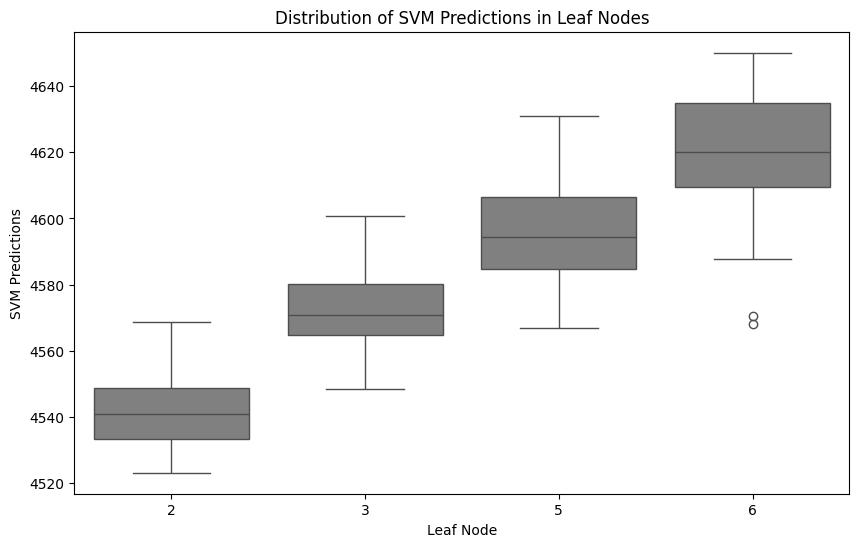

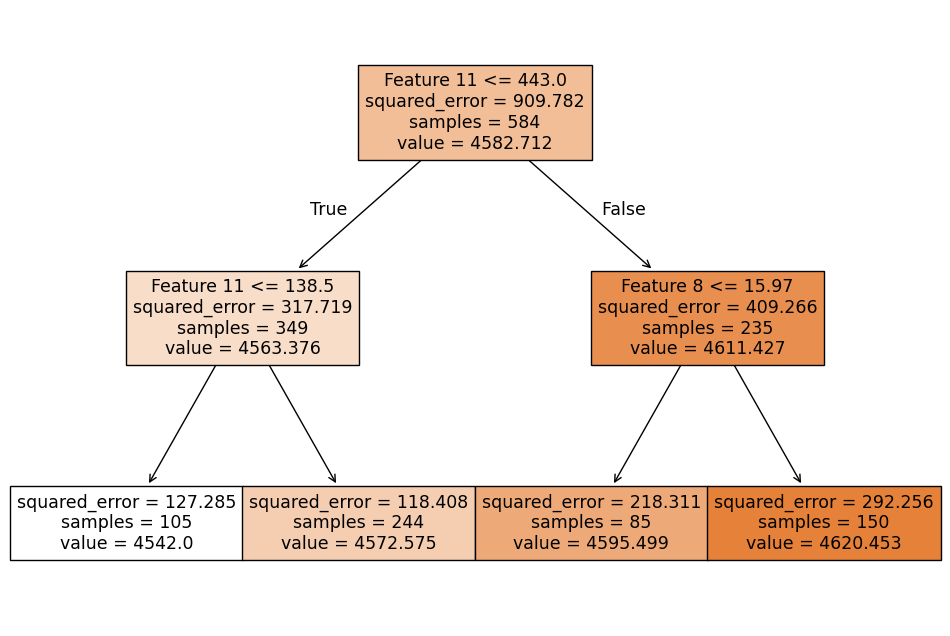

In [29]:
# Get leaf node indices for each sample
leaf_indices = tree_surrogate.apply(X_train)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({"leaf": leaf_indices, "svm_predictions": svm_predictions})

# Create boxplots for each leaf node
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="leaf", y="svm_predictions", data=plot_df, ax=ax, color="gray")
ax.set_xlabel("Leaf Node")
ax.set_ylabel("SVM Predictions")
ax.set_title("Distribution of SVM Predictions in Leaf Nodes")
plt.show()


# (Optional) Visualize the decision tree
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(
    tree_surrogate,
    filled=True,
    ax=ax,
    feature_names=[f"Feature {i + 1}" for i in range(X.shape[1])],
)
plt.show()

In [35]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

In [36]:
X = df_rfcc_preprocessed.drop("Biopsy", axis=1)
y = df_rfcc_preprocessed["Biopsy"].map({"Healthy": 0, "Cancer": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_model = RandomForestClassifier(random_state=43)  # random_stateで再現性を確保
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

In [38]:
rf_predictions = rf_model.predict(X_train)
tree_surrogate = DecisionTreeRegressor(max_depth=2)
tree_surrogate.fit(X_train, rf_predictions)  # Train on SVM predictions
surrogate_predictions = tree_surrogate.predict(X_train)
r_squared = r2_score(rf_predictions, surrogate_predictions)
print(f"R-squared of the surrogate model (Train): {r_squared:.2f}")

rf_predictions_test = rf_model.predict(X_test)
surrogate_predictions_test = tree_surrogate.predict(X_test)
r_squared_test = r2_score(rf_predictions_test, surrogate_predictions_test)
print(f"R-squared of the surrogate model (Test): {r_squared_test:.2f}")

R-squared of the surrogate model (Train): 0.06
R-squared of the surrogate model (Test): 0.00


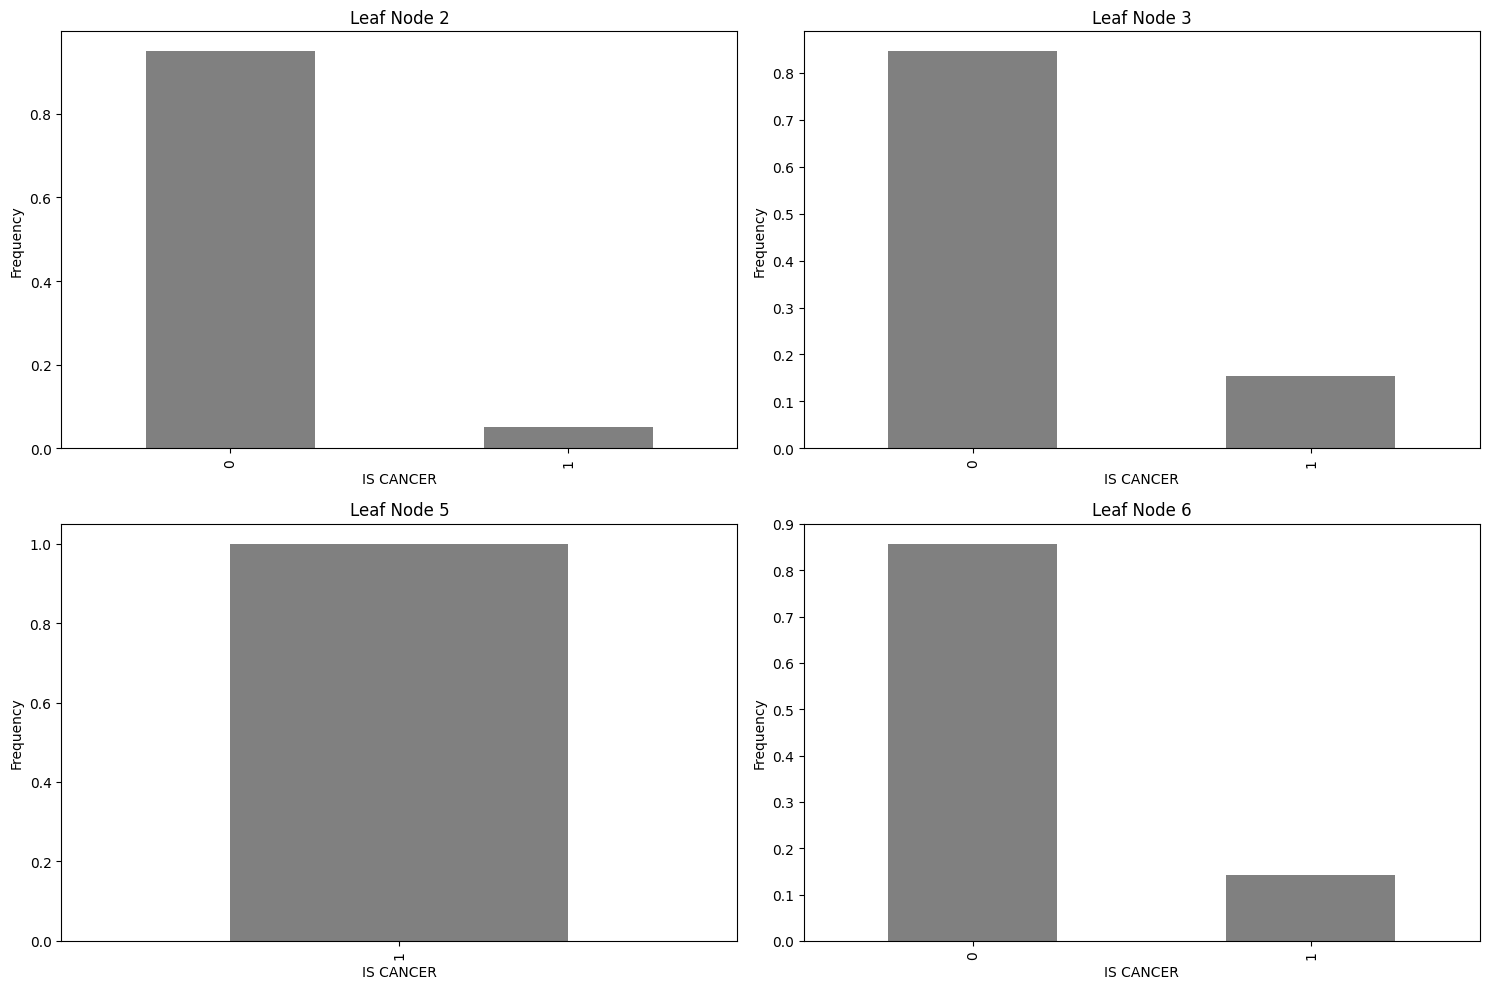

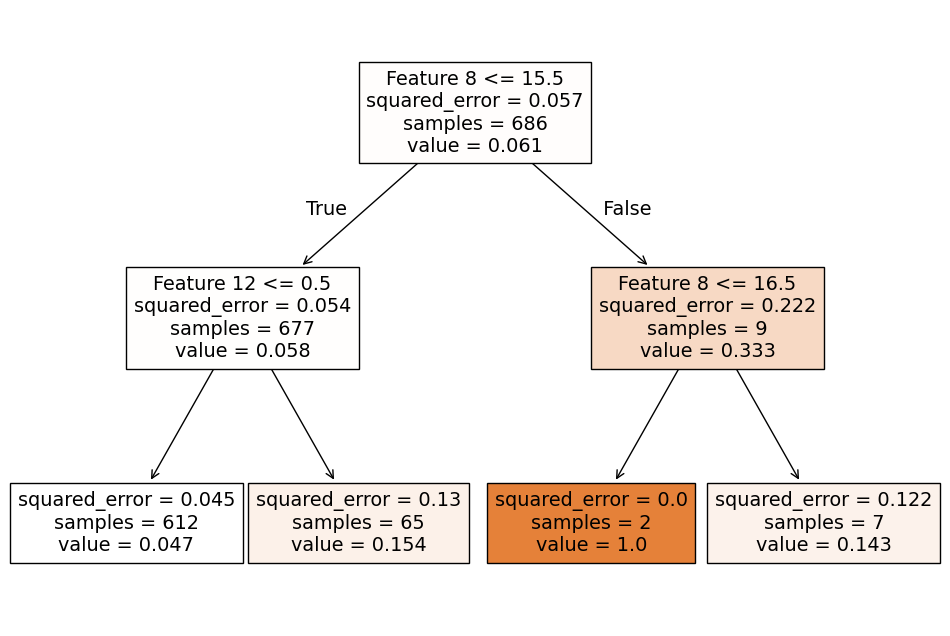

In [54]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({"leaf": leaf_indices, "is_cancer": y_train})


# Ensure svm_predictions are integers for counting
plot_df["is_cancer"] = plot_df["is_cancer"].astype(
    int
)  # Or round if they're floats close to 0/1


n_leaves = len(plot_df["leaf"].unique())
n_cols = 2
n_rows = (n_leaves + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()

for i, leaf in enumerate(sorted(plot_df["leaf"].unique())):
    ax = axes[i]
    leaf_data = plot_df.query("leaf==@leaf")["is_cancer"].value_counts(
        normalize=True
    )  # Normalize for frequencies
    leaf_data.plot(kind="bar", ax=ax, color="gray")
    ax.set_title(f"Leaf Node {leaf}")
    ax.set_xlabel("IS CANCER")
    ax.set_ylabel("Frequency")


for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()


# (Optional) Visualize the decision tree
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(
    tree_surrogate,
    filled=True,
    ax=ax,
    feature_names=[f"Feature {i + 1}" for i in range(X.shape[1])],
)
plt.show()